In [24]:
import os
import requests
import zipfile
import shutil

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA
import numpy as np

In [2]:
years= [i for i in range(1975, 2021) if i%5==0]
for i in years:
    url = f"https://static.nhtsa.gov/nhtsa/downloads/FARS/{i}/National/FARS{i}NationalCSV.zip"
    with open(f'{i}.zip', 'wb') as f:
        f.write(requests.get(url).content)
    with zipfile.ZipFile(f'{i}.zip', 'r') as zip_:
        zip_.extractall(str(i))
    os.mkdir("accident_all_years")
    source = f"{i}/accident.csv"
    dest = f"accident_all_years/{i}_accident.csv"
    shutil.copy(source, dest)

Total accidents from 1975 to 2020: 376096
Total people in accidents: 955696
Total persons died in accidents: 418619
Proportion of accidents in overnight: 32.81 %
Proportion of accidents in snowy: 1.63 %


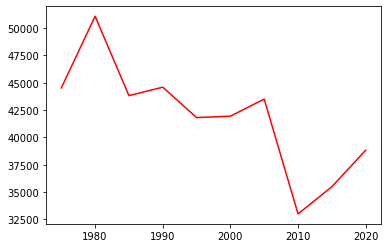

In [26]:
global_df= pd.DataFrame()
deaths= []
mean_rates= []
for i in years:
    df = pd.read_csv(f"accident_all_years/{i}_accident.csv", encoding = 'ISO-8859-1')
    global_df= pd.concat([global_df, df])
    global_df.reset_index(drop= True, inplace= True)
    fatals= df.FATALS.sum()
    deaths.append(fatals)
    top_mr = df.groupby("STATE").FATALS.agg('sum').sort_values().head().mean()
    bottom_mr = df.groupby("STATE").FATALS.agg('sum').sort_values().tail().mean()
    mean_rates.append((top_mr + bottom_mr)/5)
    
accidents_overnight= 0  
for overnight_hr in [21, 22, 23, 24, 0, 1, 2, 3]:
    accidents= global_df[global_df.HOUR==overnight_hr]
    accidents_overnight += accidents.shape[0]
    
accidents_snowy = global_df[global_df.WEATHER==4]

print("Total accidents from 1975 to 2020:", global_df.shape[0])
print(f"Total people in accidents: {global_df.PERSONS.sum()}")
print(f"Total persons died in accidents: {global_df.FATALS.sum()}")
print(f"Proportion of accidents in overnight: {round((accidents_overnight/global_df.shape[0])*100, 2)} %")
print(f"Proportion of accidents in snowy: {round((accidents_snowy.shape[0]/global_df.shape[0])*100, 2)} %")

plt.plot(years, deaths, color='red')
plt.show()

*From the above graph, we can say that the fatality rate is decreased over time*

In [10]:
print("Mean rate of fatal accidents:", round(global_df[global_df.DRUNK_DR!=0].FATALS.mean(), 2))
tdf= pd.read_csv(f"accident_all_years/1975_accident.csv", encoding = 'ISO-8859-1')
tdf= tdf.groupby("STATE").FATALS.agg('sum').sort_values()
print("Top 5:", list(tdf.tail().index))
print("Bottom 5:", list(tdf.head().index))

Mean rate of fatal accidents: 1.13
Top 5: [17, 42, 36, 48, 6]
Bottom 5: [11, 44, 2, 10, 50]


In [12]:
tdf= pd.read_csv(f"accident_all_years/1990_accident.csv", encoding= 'ISO-8859-1')
tdf= tdf.groupby("STATE").FATALS.agg('sum').sort_values()
print("Top 5:", list(tdf.tail().index))
print("Bottom 5:", list(tdf.head().index))

Top 5: [42, 36, 12, 48, 6]
Bottom 5: [11, 44, 50, 2, 38]


In [13]:
tdf= pd.read_csv(f"accident_all_years/2020_accident.csv", encoding= 'ISO-8859-1')
print("Average rate in 2020:", round(tdf.FATALS.mean(), 2))

Average rate in 2020: 1.09


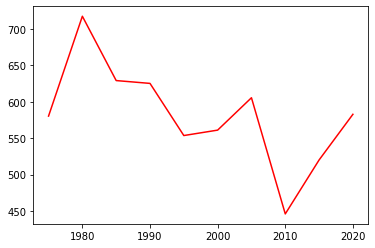

In [27]:
plt.plot(years, mean_rates, color='r')
plt.show()

*Here, we can see that with the increase in the year, the rate is getting decreased. But in 2020, it has increased again*

In [17]:
tdf= global_df[["STATE", 'MONTH', 'DAY', 'YEAR', 'HOUR', 'PERSONS', 'MAN_COLL',
                'LGT_COND', 'WEATHER', 'SCH_BUS', 'FATALS', 'DAY_WEEK', 'DRUNK_DR']].sample(n=5000)
tdf.dropna(inplace=True)
tdf = pd.DataFrame(MinMaxScaler().fit_transform(tdf), columns= tdf.columns)

In [18]:
tdf.head()

,STATE,MONTH,DAY,YEAR,HOUR,PERSONS,MAN_COLL,LGT_COND,WEATHER,SCH_BUS,FATALS,DAY_WEEK,DRUNK_DR
0,0.327273,0.909091,0.600000,0.994845,0.191919,0.011905,0.000000,0.125,0.000000,0.0,0.0,0.833333,0.2
1,0.218182,0.909091,0.400000,0.007732,0.151515,0.023810,0.040404,0.000,0.000000,0.0,0.0,0.166667,0.0
2,0.909091,0.909091,0.366667,0.997423,0.060606,0.011905,0.000000,0.375,0.091837,0.0,0.0,0.666667,0.0
3,0.090909,0.454545,0.433333,0.989691,0.202020,0.023810,0.000000,0.250,0.000000,0.0,0.0,0.500000,0.2
4,0.854545,0.363636,0.033333,0.992268,0.131313,0.071429,0.050505,0.000,0.000000,0.0,0.0,0.166667,0.0


In [20]:
knn= NearestNeighbors(n_neighbors=20)
knn.fit(tdf)
distances, indices= knn.kneighbors(tdf)
print(distances)

[[0.         0.1526706  0.16796568 ... 0.28583488 0.28748775 0.29150555]
 [0.         0.10341872 0.13253142 ... 0.26251973 0.26728501 0.27654455]
 [0.         0.28337377 0.32834625 ... 0.38697079 0.38900122 0.39212898]
 ...
 [0.         0.14175269 0.19205928 ... 0.28965619 0.29444045 0.29551589]
 [0.         0.15858744 0.15906422 ... 0.23858714 0.23954334 0.24080301]
 [0.         0.21679541 0.21897689 ... 0.35786906 0.36008502 0.36013025]]


Variance: 35.446740777265916


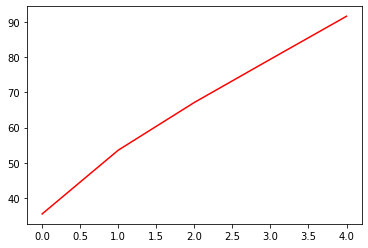

In [29]:
pca= PCA(n_components= 0.90)
pca.fit_transform(tdf)
plt.plot(np.cumsum(pca.explained_variance_ratio_*100), color='r')
print("Variance:", np.cumsum(pca.explained_variance_ratio_*100)[0])